### Initilization

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import tensorflow as tf
from nltk.stem import WordNetLemmatizer 
from keras.preprocessing.text import Tokenizer
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings('ignore')

### Data loading - visualization


0    11104
2     8572
1     7671
Name: sentiment, dtype: int64


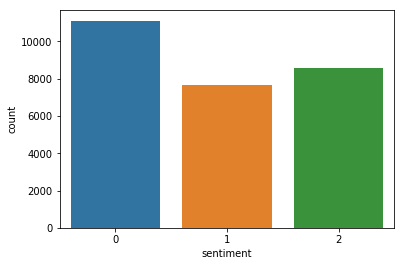

In [2]:
data = pd.read_csv('D:\Data\sentiment.csv')
data = data.dropna()
X = data['selected_text']
y = data['sentiment']
print(y.value_counts())
sns.countplot(y)
plt.show()

### Text cleaning 
#### Removing stopwords, punctuation signs, url pattern and so on.

In [3]:
def transform_text(text):
    text = text.lower()
    
    r = re.findall('@[\w]*', text)
    
    for w in r:
        text = text.replace(w, ' ')
    text = text.replace('[^a-zA-Z#]', '')
    text = ' '.join([word for word in text.split() if len(word) > 3])
    
    text = re.sub(r'\$%,.\:\?', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    words = text.split(" ")
    words = [lemma.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    text = ' '.join(words) 
    
    return text

In [4]:
lemma = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahmoudi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahmoudi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

### Tokenization

In [5]:
X = X.apply(lambda x: transform_text(x))


max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
tweets = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size = 0.3)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
tweets

array([[  0,   0,   0, ...,   0,   0,   7],
       [  0,   0,   0, ...,   0,   0, 236],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   1],
       [  0,   0,   0, ...,   0,   0, 360],
       [  0,   0,   0, ...,   7, 424, 461]])

### Model construction

In [7]:
embed_dim = 20
lstm_out = 15
max_words = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 100, batch_size = 128, validation_data = (X_test, y_test))
model.save('sentiment_analyzer.hdf5')

Epoch 1/100
150/150 [==============================] - 26s 130ms/step - loss: 0.9678 - accuracy: 0.5217 - val_loss: 0.8421 - val_accuracy: 0.5995
Epoch 2/100
150/150 [==============================] - 19s 124ms/step - loss: 0.7385 - accuracy: 0.7241 - val_loss: 0.6726 - val_accuracy: 0.7467
Epoch 3/100
150/150 [==============================] - 18s 123ms/step - loss: 0.5827 - accuracy: 0.7801 - val_loss: 0.5946 - val_accuracy: 0.7609
Epoch 4/100
150/150 [==============================] - 20s 135ms/step - loss: 0.5028 - accuracy: 0.8046 - val_loss: 0.5712 - val_accuracy: 0.7707
Epoch 5/100
150/150 [==============================] - 23s 151ms/step - loss: 0.4564 - accuracy: 0.8239 - val_loss: 0.5691 - val_accuracy: 0.7718
Epoch 6/100
150/150 [==============================] - 23s 156ms/step - loss: 0.4274 - accuracy: 0.8346 - val_loss: 0.5752 - val_accuracy: 0.7762
Epoch 7/100
150/150 [==============================] - 23s 150ms/step - loss: 0.4052 - accuracy: 0.8435 - val_loss: 0.5880 -

In [8]:
y_pre = model.predict(X_test)

In [9]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_pre, axis = 1)))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      3403
           1       0.65      0.75      0.69      2285
           2       0.78      0.74      0.76      2517

    accuracy                           0.74      8205
   macro avg       0.73      0.74      0.73      8205
weighted avg       0.74      0.74      0.74      8205

